# WindPower Forecasting Task


TIMESTAMP: Self-explanatory. 
TARGETVAR: Hourly-mean wind power normalised by the maximum output of the wind farm. U10: Forecast zonal wind velocity (m/s) at 10m above ground. 
V10: Forecast meridional wind velocity (m/s) at 10m above ground. 
U100: Forecast zonal wind velocity (m/s) at 100m above ground. 
V100: Forecast meridional wind velocity (m/s) at 100m above ground.   

Wind power data are missing from the final day of the dataset. Your task is to predict the wind power output for this day based on the available weather forecasts.   

In a programming language of your choice, we would like you to do the following: 

1. Perform a brief analysis of the data and identify features that may be important for wind power forecasting 
2. Write and test a simple function to predict the wind power production (TARGETVAR) from the available explanatory variables 
3. Be able to discuss how you would evaluate and proceed to improve your forecast’s performance 

We will not be assessing the sophistication of your forecasting function of the accuracy of your forecasts, but we will be looking for the following: 

1. Good analytical judgement 
2. An ability to effectively communicate data analysis, both orally and through use of visualisations 
3. Sound use of a programming language. Please include 1-2 slides on how you have structured your code and what in-built functions and packages you have used.   

In [1]:
from fbprophet import Prophet
import numpy as np
import pandas as pd
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from pandas.tools.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet

from fbprophet.diagnostics import cross_validation

%matplotlib inline  

C:\Users\Muaaz\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
wind_df = pd.read_csv('WindPowerForecastingData TASK.csv')

wind_df['TIMESTAMP'] = pd.to_datetime(wind_df['TIMESTAMP'])
# wind_df.index = wind_df['TIMESTAMP']
# del wind_df['TIMESTAMP']
wind_df.head(2)

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761


In [3]:
wind_df.describe()

,TARGETVAR,U10,V10,U100,V100
count,16765.000000,16800.000000,16800.000000,16800.000000,16800.000000
mean,0.303185,0.935519,-0.250466,1.568721,-0.554659
std,0.289702,2.556424,2.919984,4.266318,5.028343
min,0.000000,-7.494252,-9.993858,-10.910809,-15.294866
25%,0.063340,-1.062387,-2.337600,-1.746650,-4.613866
50%,0.206841,0.788789,-0.039825,1.487808,0.132922
75%,0.479184,2.585812,1.927597,4.682327,3.488219
max,1.000000,11.117029,9.508798,16.988418,14.314416


In [3]:
wind_train = wind_df[:-24]
wind_train.tail()

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
16771,2013-11-29 20:00:00,0.034301,-2.014530,1.793392,-4.502124,3.949871
16772,2013-11-29 21:00:00,0.104407,-3.366064,2.831022,-4.991581,4.218858
16773,2013-11-29 22:00:00,0.114839,-3.433361,2.457599,-4.796116,3.407203
16774,2013-11-29 23:00:00,0.162579,-3.224261,2.049055,-4.407834,2.755195
16775,2013-11-30 00:00:00,0.096232,-2.869353,1.685961,-3.871232,2.200453


In [4]:
wind_test = wind_df[-24:]
wind_test.head()

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
16776,2013-11-30 01:00:00,NaN,-2.695560,1.204642,-3.581017,1.507665
16777,2013-11-30 02:00:00,NaN,-2.590272,1.081529,-3.420896,1.317269
16778,2013-11-30 03:00:00,NaN,-2.544634,0.980526,-3.350945,1.175278
16779,2013-11-30 04:00:00,NaN,-2.405717,0.823745,-3.156395,0.952611
16780,2013-11-30 05:00:00,NaN,-2.450555,0.770479,-3.213230,0.888715


In [5]:
wind_df.count()

TIMESTAMP    16800
TARGETVAR    16765
U10          16800
V10          16800
U100         16800
V100         16800
dtype: int64

##### Check for missing values

In [7]:
wind_df.isnull().sum()

TIMESTAMP     0
TARGETVAR    35
U10           0
V10           0
U100          0
V100          0
dtype: int64

In [8]:
wind_train.isnull().sum()

TIMESTAMP     0
TARGETVAR    11
U10           0
V10           0
U100          0
V100          0
dtype: int64

##### Impute Missing values
instead of dropping rows (In training set for TargetVAR) to have uninterrupted time series
Also a small percentage of values are missing

Technique for Imputing
Assuming missing value is same as in the last hour (Or last present record)
If 2:00AM Target VAR is missing we fill it up with 1:00AM

In [6]:
wind_train = wind_train.fillna(method='pad', limit=1)
wind_train.isnull().sum()

TIMESTAMP    0
TARGETVAR    1
U10          0
V10          0
U100         0
V100         0
dtype: int64

One value still missing using backfill instead of forward fill here!

In [7]:
wind_train = wind_train.fillna(method='bfill', limit=1)
wind_train.isnull().sum()

TIMESTAMP    0
TARGETVAR    0
U10          0
V10          0
U100         0
V100         0
dtype: int64

##### Normalizing the data before data between 0 and 1!

In [8]:
from sklearn import preprocessing

x = wind_train[['TARGETVAR','U10','V10','U100','V100']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled.shape
WN_train = pd.DataFrame(x_scaled)
WN_train.columns = ['TARGETVAR','U10','V10','U100','V100']
WN_train['TIMESTAMP'] = wind_train['TIMESTAMP']
WN_train.head()


,TARGETVAR,U10,V10,U100,V100,TIMESTAMP
0,0.000000,0.516829,0.374918,0.493744,0.392741,2012-01-01 01:00:00
1,0.054879,0.538165,0.420297,0.510970,0.433314,2012-01-01 02:00:00
2,0.110234,0.546253,0.470261,0.516834,0.475553,2012-01-01 03:00:00
3,0.165116,0.534716,0.505070,0.506324,0.504549,2012-01-01 04:00:00
4,0.156940,0.523347,0.532411,0.497092,0.527793,2012-01-01 05:00:00


## Data Analysis

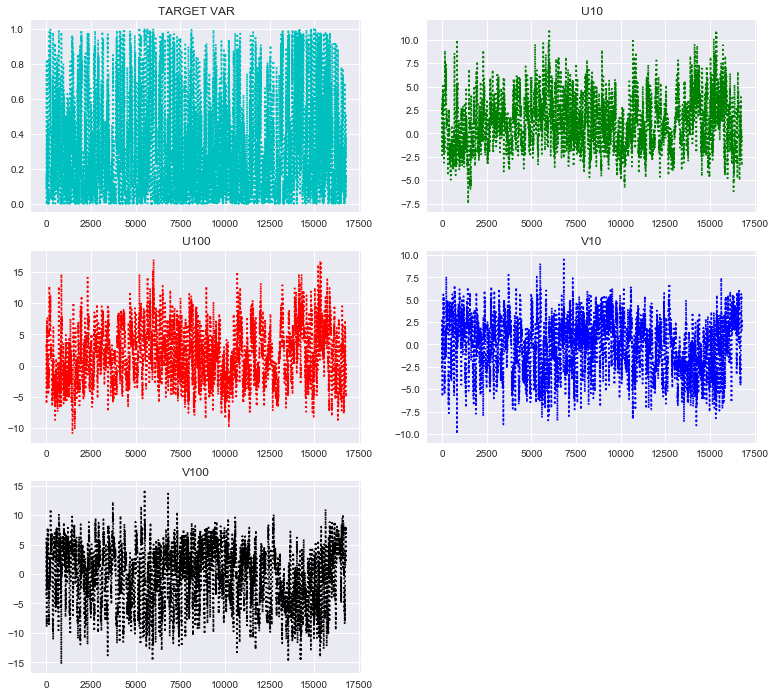

In [16]:
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(321)
ax1.plot(wind_train.index, wind_train['TARGETVAR'], label='TARGET VAR', color='c', linestyle = ':')
ax1.set_title('TARGET VAR')

ax2 = fig.add_subplot(322)
ax2.plot(wind_train.index, wind_train['U10'], label='U10', color='g', linestyle = ':')
ax2.set_title('U10')

ax3 = fig.add_subplot(323)
ax3.plot(wind_train.index, wind_train['U100'], label='U10', color='r', linestyle = ':')
ax3.set_title('U100')

ax4 = fig.add_subplot(324)
ax4.plot(wind_train.index, wind_train['V10'], label='U10', color='b', linestyle = ':')
ax4.set_title('V10')

ax5 = fig.add_subplot(325)
ax5.plot(wind_train.index, wind_train['V100'], label='U10', color='k', linestyle = ':')
ax5.set_title('V100')

ax1.grid('on')

We have data from 2012 till 2013...
The mean and variance of the series does not look like a function of time !!! Looks like series is almost stationary. Although hard to say for sure since its hard to judge covariance in the charts


No outlier detected from visuals!

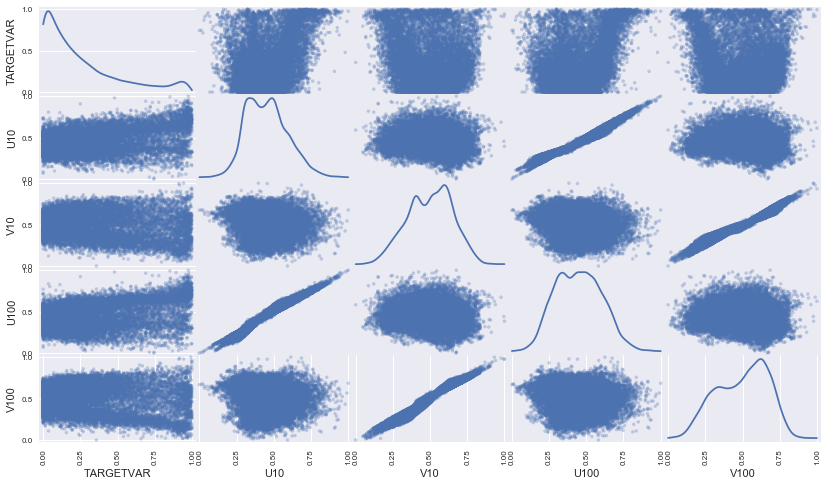

In [75]:
pd.plotting.scatter_matrix(wind_train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

+ V10 and V100 have positive trends (Both being meridional wind speeds)
+ U10 and U100 both have positive trends (Both being zonal wind speeds)


#### AUTOCORRELATION!

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  if __name__ == '__main__':


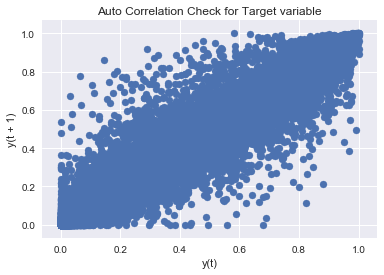

In [130]:
lag_plot(wind_train['TARGETVAR'])
plt.title('Auto Correlation Check for Target variable')
plt.show()


C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  if __name__ == '__main__':


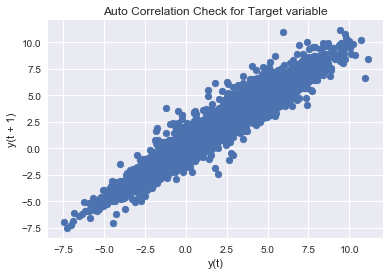

In [32]:
lag_plot(wind_train['U10'])
plt.title('Auto Correlation Check for Target variable')
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  if __name__ == '__main__':


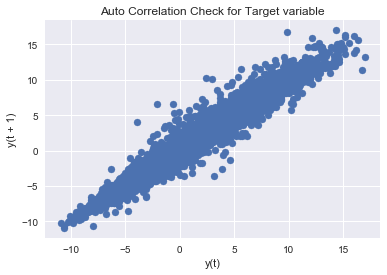

In [33]:
lag_plot(wind_train['U100'])
plt.title('Auto Correlation Check for Target variable')
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  if __name__ == '__main__':


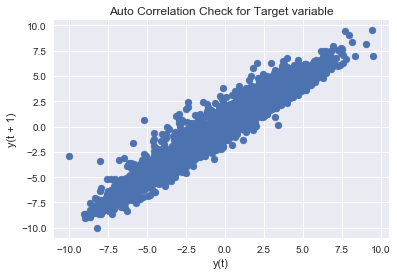

In [34]:
lag_plot(wind_train['V10'])
plt.title('Auto Correlation Check for Target variable')
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  if __name__ == '__main__':


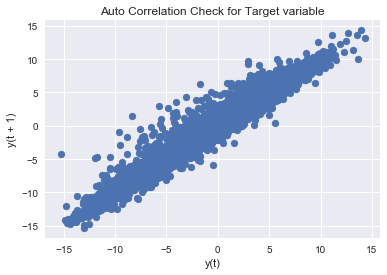

In [35]:
lag_plot(wind_train['V100'])
plt.title('Auto Correlation Check for Target variable')
plt.show()

Looks like t and t+1 values have positive correlation, autoregression model would be a good choice!
and the series is def not a white noise!

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


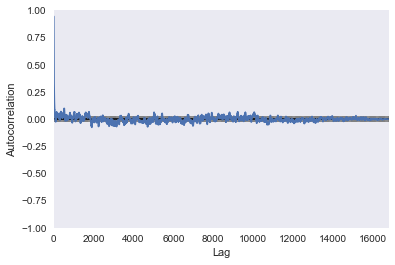

In [144]:
autocorrelation_plot(wind_train['TARGETVAR'])
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


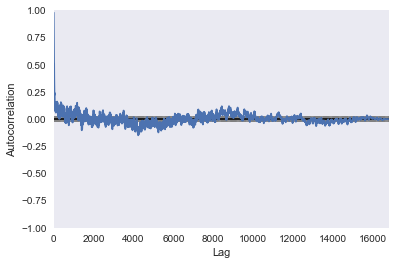

In [28]:
autocorrelation_plot(wind_train['U10'])
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


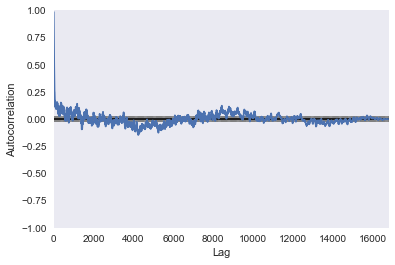

In [31]:
autocorrelation_plot(wind_train['U100'])
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


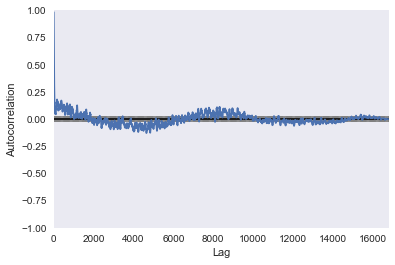

In [29]:
autocorrelation_plot(wind_train['V10'])
plt.show()

C:\Users\Muaaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


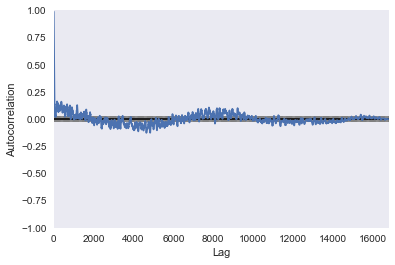

In [30]:
autocorrelation_plot(wind_train['V100'])
plt.show()

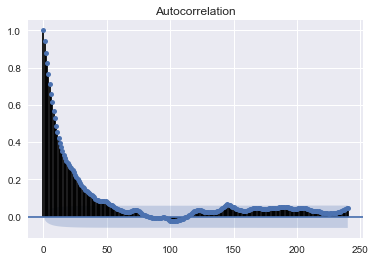

In [139]:
plot_acf(wind_train['TARGETVAR'], lags=240)
plt.show()

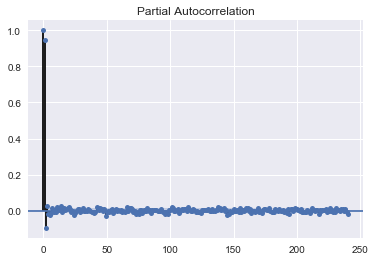

In [9]:
plot_pacf(wind_train['TARGETVAR'], lags=240)
plt.show()

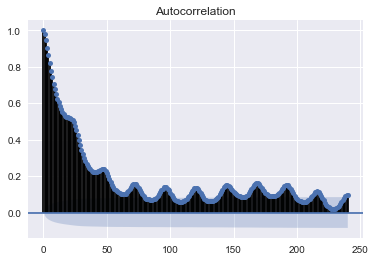

In [145]:
plot_acf(wind_train['U10'], lags=240)
plt.show()

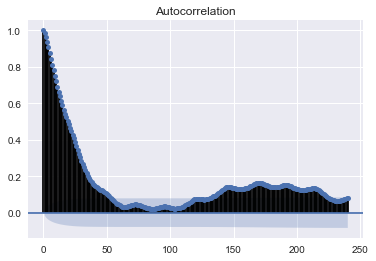

In [146]:
plot_acf(wind_train['V100'], lags=240)
plt.show()

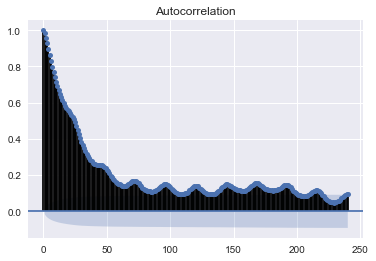

In [147]:
plot_acf(wind_train['U100'], lags=240)
plt.show()

The values nearby have positive correlation which diminishes at the end

#### Observation Distribution without Temporal info!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001498FA3F5C0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001498FFEECF8>]], dtype=object)

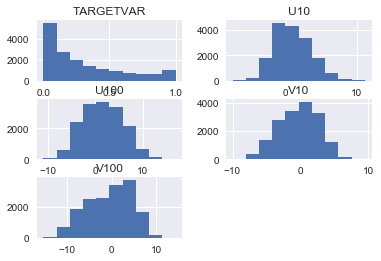

In [17]:
wind_train.hist()

Looks like all features provided are from a normal distribution

#### Facebook Prophet library for TimeSeries Visualisation

Fbprophet is quick to observe seasonality and trend in timeseries

In [25]:
#Preparing ds and y column for prophet
prophet_df = pd.DataFrame()
prophet_df['ds'] = wind_train['TIMESTAMP']
prophet_df['y'] = wind_train['TARGETVAR']
model = Prophet().fit(prophet_df)
future_data = model.make_future_dataframe(periods=24, freq = 'H')
forecast_data = model.predict(future_data)
print(forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


                       ds      yhat  yhat_lower  yhat_upper
16795 2013-11-30 20:00:00  0.333487   -0.009504    0.689424
16796 2013-11-30 21:00:00  0.332722   -0.039889    0.682954
16797 2013-11-30 22:00:00  0.331415   -0.018248    0.695378
16798 2013-11-30 23:00:00  0.329394   -0.042257    0.701440
16799 2013-12-01 00:00:00  0.328091   -0.020241    0.708636


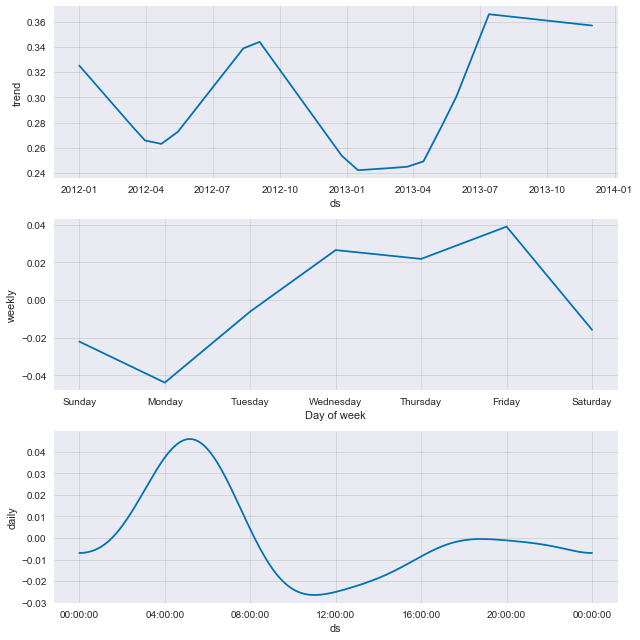

In [27]:
model.plot_components(forecast_data)
plt.show()

## Models

#### AUTO REGRESSION MODEL

Looking at ACF and PACF plot it seems an AR model would be a good choice!

In [155]:
tscv = TimeSeriesSplit(n_splits=30)
X = WN_train[['TARGETVAR']]
X_arr = X.values
X_arr1 = X_arr[:16056,]
X_arr2 = X_arr[16056:,]
Y = WN_train[['TARGETVAR']]
Y_arr = Y.values
Y_arr1 = Y_arr[:16056,]
Y_arr2 = Y_arr[16056:,]
avg_mse_AR = []

In [156]:
for train_index, test_index in tscv.split(X_arr2):
    y_train, y_test = np.concatenate((Y_arr1,Y_arr2[train_index]), axis=0), Y_arr2[test_index]
    model = AR(y_train)
    model_fit = model.fit()
#     print('Lag: %s' % model_fit.k_ar)
#     print('Coefficients: %s' % model_fit.params)
    # make predictions
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=False)
    mse = mean_squared_error(y_test, y_pred)
    avg_mse_AR.append(mse)
print (sum(avg_mse_AR)/len(avg_mse))

0.0458945464489


#### Machine Learning Approach with Linear regression Model (Assuming no Time Series)

In [111]:
# Create forward cross validation to evaluate a model

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=30)
X = WN_train[['U10','V10','U100','V100']]
X_arr = X.values
X_arr1 = X_arr[:16056,]
X_arr2 = X_arr[16056:,]
Y = WN_train[['TARGETVAR']]
Y_arr = Y.values
Y_arr1 = Y_arr[:16056,]
Y_arr2 = Y_arr[16056:,]

avg_mse = []

In [112]:
for train_index, test_index in tscv.split(X_arr2):
    X_train, X_test = np.concatenate((X_arr1,X_arr2[train_index]), axis=0), X_arr2[test_index]
    y_train, y_test = np.concatenate((Y_arr1,Y_arr2[train_index]), axis=0), Y_arr2[test_index]
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

#     # The coefficients
#     print('Coefficients: \n', regr.coef_)
#     # The mean squared error
#     print("Mean squared error: %.2f", mse)
#     print("-----------------")
    avg_mse.append(mse)
print (sum(avg_mse)/len(avg_mse))

0.0520238392479


In [120]:
tscv = TimeSeriesSplit(n_splits=30)
X = WN_train[['U100','V100']]
X_arr = X.values
X_arr1 = X_arr[:16056,]
X_arr2 = X_arr[16056:,]
Y = WN_train[['TARGETVAR']]
Y_arr = Y.values
Y_arr1 = Y_arr[:16056,]
Y_arr2 = Y_arr[16056:,]

avg_mse1 = []

In [121]:
for train_index, test_index in tscv.split(X_arr2):
    X_train, X_test = np.concatenate((X_arr1,X_arr2[train_index]), axis=0), X_arr2[test_index]
    y_train, y_test = np.concatenate((Y_arr1,Y_arr2[train_index]), axis=0), Y_arr2[test_index]
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

#     # The coefficients
#     print('Coefficients: \n', regr.coef_)
#     # The mean squared error
#     print("Mean squared error: %.2f", mse)
#     print("-----------------")
    avg_mse1.append(mse)
print (sum(avg_mse)/len(avg_mse))

0.0520238392479


In [122]:
len(avg_mse1)

30

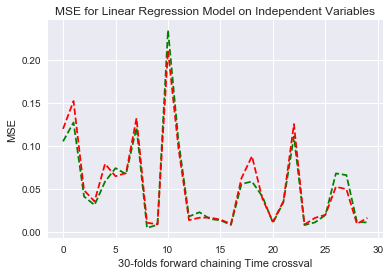

In [125]:
plt.plot(avg_mse,'g--',label = 'All variables')
plt.plot(avg_mse1, 'r--',label ='Only two variables')
plt.title('MSE for Linear Regression Model on Independent Variables')
plt.ylabel('MSE')
plt.xlabel('30-folds forward chaining Time crossval')
plt.show()

In [11]:
import tsfresh